In [1]:
from setup import *
from utils import *

In [2]:
spp = 16

In [3]:
materials = create_materials(with_fluids=False)
# components = load_components(materials)
components = {}
components.update({ # Add 'bubbles' to the scene
    # 'bubble0' : mi.load_dict({
    #     'type': 'sphere',
    #     # 'bsdf': materials['bubble_mat'],
    #     'focused-emitter': materials['emitter'],
    #     'to_world': mi.ScalarTransform4f.translate([5.0, 0.0, -12.0]).scale(0.5),
    # }),
    'bubble1' : mi.load_dict({
        'type': 'sphere',
        # 'bsdf': materials['bubble_mat'],
        'focused-emitter': materials['emitter'],
        'to_world': mi.ScalarTransform4f.translate([-8.0, 4.0, -18.0]).scale(0.5),
    }),
    'light' : {'type': 'constant'}
})

# # Remove all refractive surfaces (for now)
# del components['viewports_outer']
# del components['viewports_inner']
# del components['outer_jar_outer_surface']
# del components['outer_jar_inner_surface']
# del components['inner_jar_outer_surface']
# del components['inner_jar_inner_surface']

cam1 = create_sensor(sensor_number=1, sample_count=spp)
cam2 = create_sensor(sensor_number=2, sample_count=spp)
cam3 = create_sensor(sensor_number=3, sample_count=spp)

cam1_scene = load_scene(components=components, sensor=cam1)
cam2_scene = load_scene(components=components, sensor=cam2)
cam3_scene = load_scene(components=components, sensor=cam3)

In [4]:
# Create checkerboard scene so OpenCV can determine camera pose with PnP
c_scale = 7.0
checkerboard_scene = {
    'checkerboard': {
        'type': 'ply',
        'filename': 'test_scenes/meshes/checkerboard.ply',
        'face_normals': True,
        'bsdf': {
            'type': 'diffuse',
            'id': 'black-bsdf',
            'reflectance': {'type': 'spectrum', 'value': 0.0},
            },
        'to_world': mi.ScalarTransform4f.scale(c_scale),
    },
    'light': {
        'type': 'constant'
    }
}
cam1_checkerboard = load_scene(components=checkerboard_scene, sensor=cam1)
cam2_checkerboard = load_scene(components=checkerboard_scene, sensor=cam2)
cam3_checkerboard = load_scene(components=checkerboard_scene, sensor=cam3)

In [5]:
def get_PnP_points(scene):
    img = render(scene, denoise=False)

    x_axis_pts = np.linspace(c_scale*0.8, -c_scale*0.8, 9)
    y_axis_pts = np.linspace(-c_scale*0.8, c_scale*0.8, 9)
    z_axis_pts = np.zeros(9)
    objp = np.vstack([np.dstack((x_axis_pts, np.full(9, y), z_axis_pts)) for y in y_axis_pts]).reshape(81, 3)
    imgp = None

    uint_img = np.array(np.average(img, axis=2)*255, dtype=np.uint8) # convert render to single channel uint8 numpy array

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(uint_img, (9,9), None)

    # If corners are found, add the object points and image points (after doing subpixel refinement)
    if ret == True:
        imgp = cv2.cornerSubPix(uint_img, corners, 
                                    (11,11), # search window
                                    (-1,-1), # zero zone (not used)
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)) # termination criteria
    else:
        print("Chessboard corners not found!")

    drawn = cv2.drawChessboardCorners(uint_img, (9,9), imgp, True)
    plt.figure(figsize=(12, 8))
    plt.imshow(drawn)

    return objp, imgp

In [6]:
def construct_projection_matrix(objp, imgp, mat):
    ret, rvec, tvec = cv2.solvePnP(objp, imgp, mat, None) # (no distortion coeffs)
    if not ret: 
        print("Error! Could not solve PnP.")
        return None
    
    R, _ = cv2.Rodrigues(rvec)
    pose = np.concatenate((R, tvec), 1)
    print("Pose Matrix:\n", pose, end='\n')

    # proj = mat @ pose
    # print("Projection Matrix:\n", proj, end='\n\n')

    proj = pose

    return proj

Pose Matrix:
 [[-0.6565252  -0.65624344  0.3719129   4.04661318]
 [-0.72944831  0.67788321 -0.0915397  -1.02598124]
 [-0.19204119 -0.33138936 -0.92374308 21.05484469]]
Pose Matrix:
 [[-9.23654897e-01  1.29278846e-04  3.83225279e-01  4.17046166e+00]
 [ 3.19798522e-04  9.99999855e-01  4.33438639e-04 -1.97053206e-02]
 [-3.83225167e-01  5.22902599e-04 -9.23654805e-01  2.10564776e+01]]
Pose Matrix:
 [[-0.65641117 -0.65635318  0.37192053  4.0464068 ]
 [-0.6773529   0.72982114  0.09248861  0.98732903]
 [-0.33214066 -0.19121089 -0.92364548 21.05983834]]


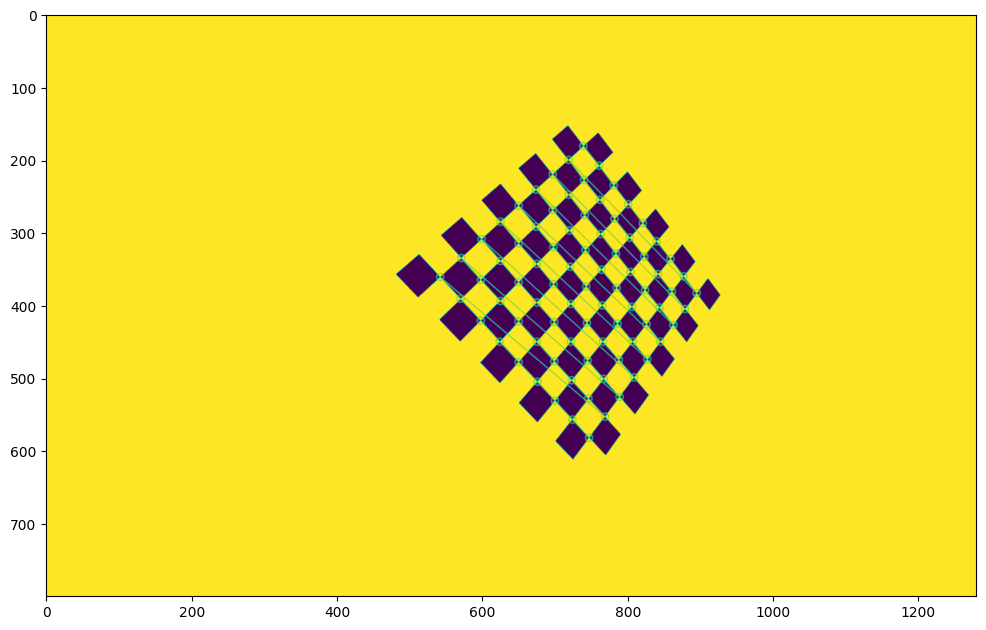

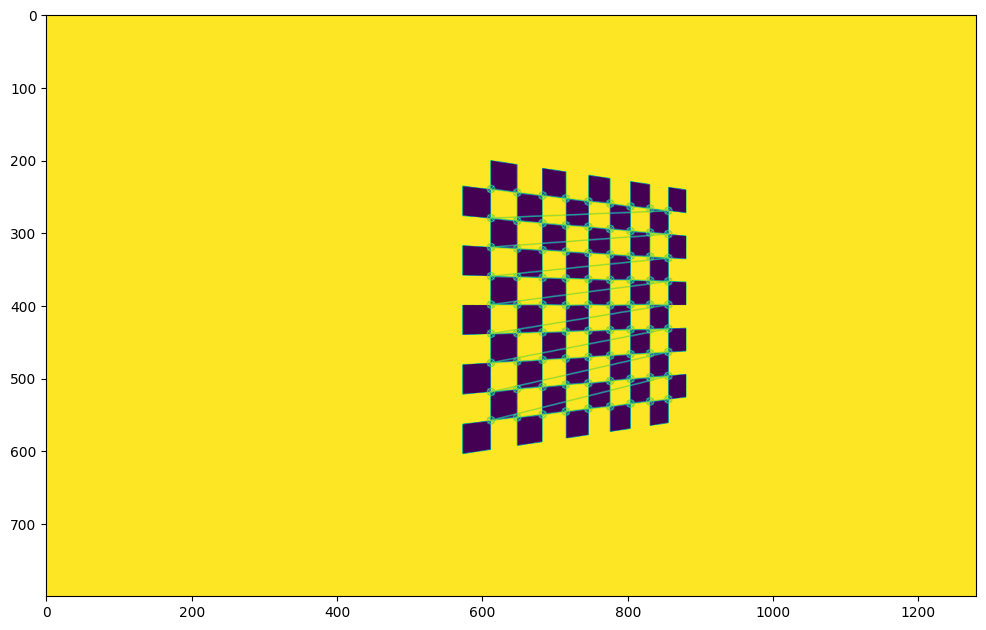

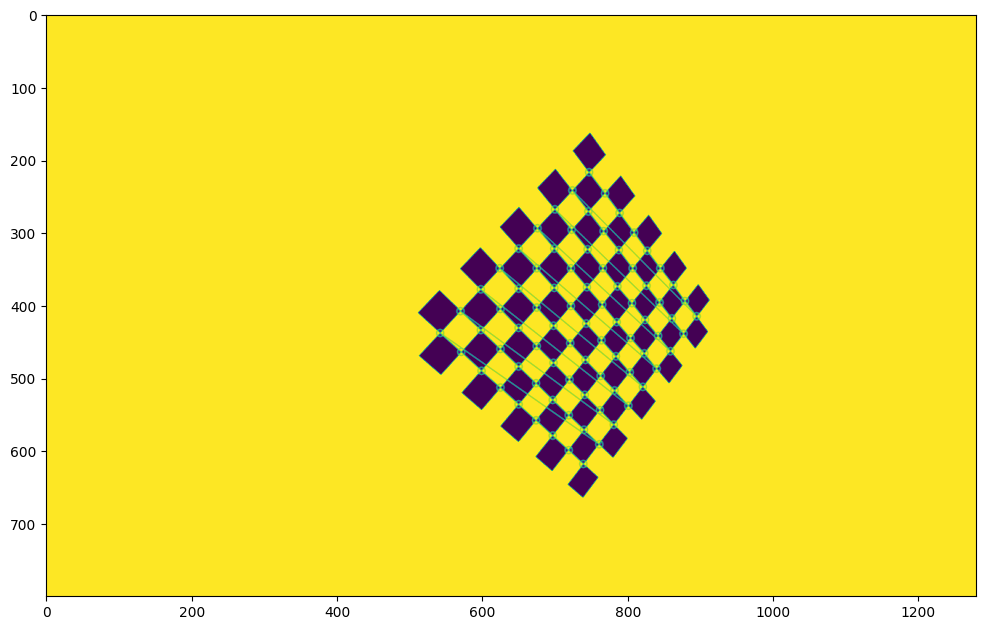

In [7]:
cam1_objp, cam1_imgp = get_PnP_points(cam1_checkerboard)
cam2_objp, cam2_imgp = get_PnP_points(cam2_checkerboard)
cam3_objp, cam3_imgp = get_PnP_points(cam3_checkerboard)

cam1_mat = get_ideal_camera_matrix(cam1['fov'], cam1['film']['width'], cam1['film']['height'])
cam2_mat = get_ideal_camera_matrix(cam2['fov'], cam2['film']['width'], cam2['film']['height'])
cam3_mat = get_ideal_camera_matrix(cam3['fov'], cam3['film']['width'], cam3['film']['height'])

cam1_proj = construct_projection_matrix(cam1_objp, cam1_imgp, cam1_mat)
cam2_proj = construct_projection_matrix(cam2_objp, cam2_imgp, cam2_mat)
cam3_proj = construct_projection_matrix(cam3_objp, cam3_imgp, cam3_mat)

In [8]:
render1_rgb = render(cam1_scene, denoise=False) 
render2_rgb = render(cam2_scene, denoise=False)
render3_rgb = render(cam3_scene, denoise=False)

# Take only red channel
render1 = render1_rgb[:,:,0]
render2 = render2_rgb[:,:,0]
render3 = render3_rgb[:,:,0]

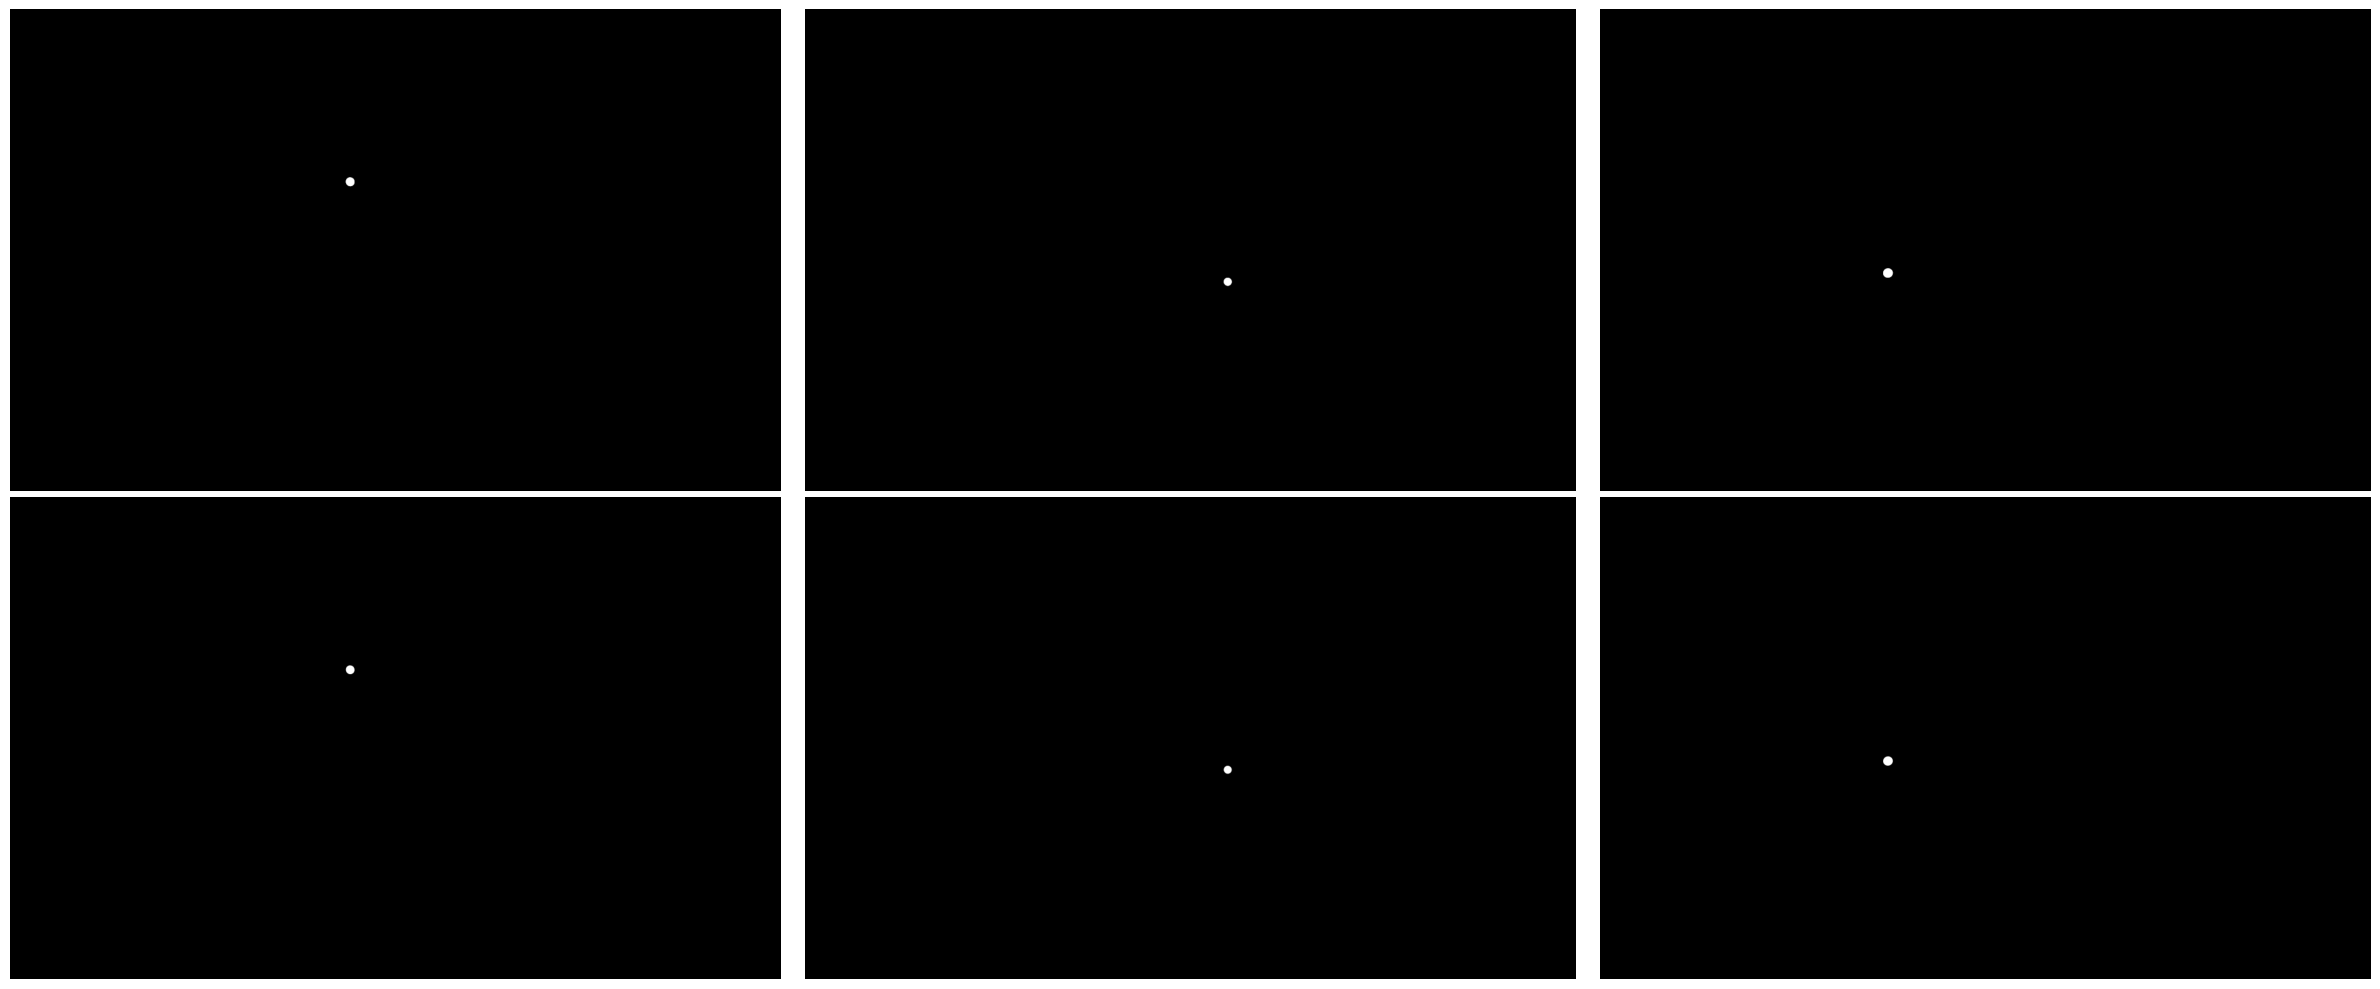

In [9]:
threshold = 0.99
threshold_render1 = np.where(render1>threshold, render1, 0).astype(np.uint8)
threshold_render2 = np.where(render2>threshold, render2, 0).astype(np.uint8)
threshold_render3 = np.where(render3>threshold, render3, 0).astype(np.uint8)

fig, ax = plt.subplots(2, 3, figsize=(24,10))
ax[0,0].imshow(render1**0.25, cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(render2**0.25, cmap='gray')
ax[0,1].axis('off')
ax[0,2].imshow(render3**0.25, cmap='gray')
ax[0,2].axis('off')

ax[1,0].imshow(threshold_render1, cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(threshold_render2, cmap='gray')
ax[1,1].axis('off')
ax[1,2].imshow(threshold_render3, cmap='gray')
ax[1,2].axis('off')
fig.tight_layout()

[[564. ]
 [286.5]]
[[702. ]
 [451.5]]
[[477.]
 [438.]]


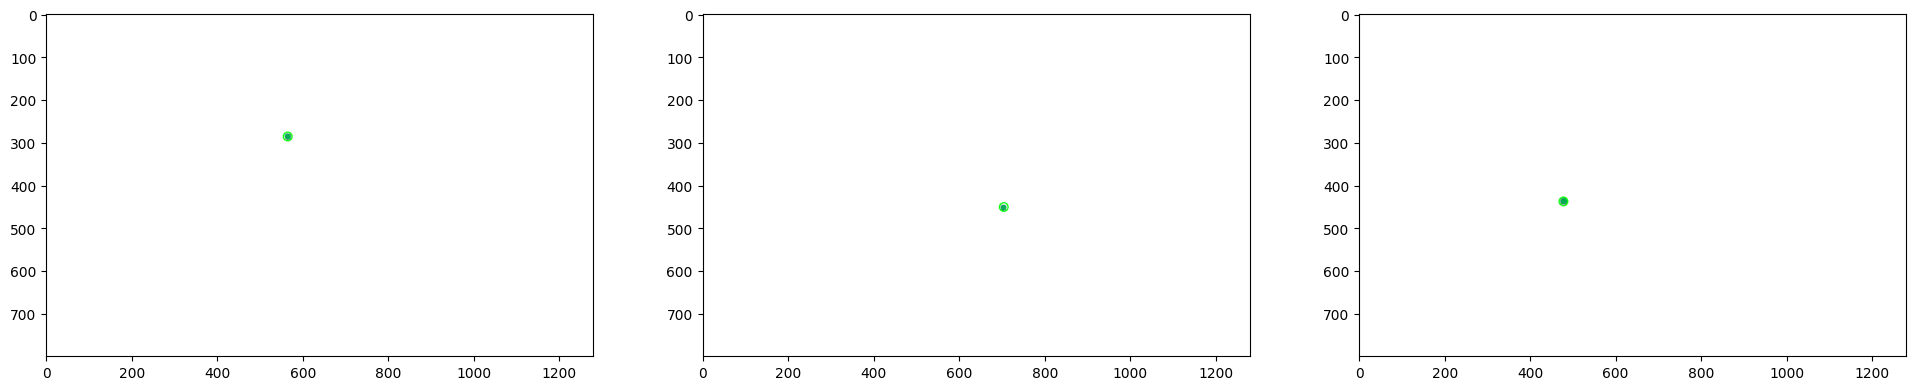

In [14]:
hough_params = {
    'method': cv2.HOUGH_GRADIENT_ALT,
    'dp': 1.5,
    'minDist': 10,
    'param1': 150,
    'param2': 0.9,
    'minRadius': 2,
    'maxRadius': 20
}

bubbles_render1 = cv2.HoughCircles(threshold_render1, **hough_params).reshape(-1, 3)[:,:2].T
bubbles_render2 = cv2.HoughCircles(threshold_render2, **hough_params).reshape(-1, 3)[:,:2].T
bubbles_render3 = cv2.HoughCircles(threshold_render3, **hough_params).reshape(-1, 3)[:,:2].T

print(bubbles_render1)
print(bubbles_render2)
print(bubbles_render3)

drawn1 = cv2.circle(np.array(render1_rgb * 255, dtype=np.uint8), (int(bubbles_render1[0,0]), int(bubbles_render1[1,0])), 10, (0, 255, 0), 2)
drawn2 = cv2.circle(np.array(render2_rgb * 255, dtype=np.uint8), (int(bubbles_render2[0,0]), int(bubbles_render2[1,0])), 10, (0, 255, 0), 2)
drawn3 = cv2.circle(np.array(render3_rgb * 255, dtype=np.uint8), (int(bubbles_render3[0,0]), int(bubbles_render3[1,0])), 10, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 3, figsize=(24,10))
ax[0].imshow(drawn1)
# ax[0].axis('off')
ax[1].imshow(drawn2)
# ax[1].axis('off')
ax[2].imshow(drawn3)
# ax[2].axis('off')

In [11]:
cam1_proj_ = np.array(cam1['to_world'].matrix)[:3,:]
cam2_proj_ = np.array(cam2['to_world'].matrix)[:3,:]
cam3_proj_ = np.array(cam3['to_world'].matrix)[:3,:]

# cam1_proj_ = get_ideal_camera_matrix(cam1['fov'], cam1['film']['width'], cam1['film']['height']) @ np.array(cam1['to_world'].matrix)[:3,:]
# cam2_proj_ = get_ideal_camera_matrix(cam1['fov'], cam2['film']['width'], cam2['film']['height']) @ np.array(cam2['to_world'].matrix)[:3,:]
# cam3_proj_ = get_ideal_camera_matrix(cam1['fov'], cam3['film']['width'], cam3['film']['height']) @ np.array(cam3['to_world'].matrix)[:3,:]

print("Camera 1 OpenCV Projection")
print(cam1_proj)
print("Camera 1 Render Projection")
print(cam1_proj_)
print()

print("Camera 2 OpenCV Projection")
print(cam2_proj)
print("Camera 2 Render Projection")
print(cam2_proj_)
# print("Difference")
# print(cam2_proj - cam2_proj_)
print()

print("Camera 3 OpenCV Projection")
print(cam3_proj)
print("Camera 3 Render Projection")
print(cam3_proj_)
print()

Camera 1 OpenCV Projection
[[-0.6565252  -0.65624344  0.3719129   4.04661318]
 [-0.72944831  0.67788321 -0.0915397  -1.02598124]
 [-0.19204119 -0.33138936 -0.92374308 21.05484469]]
Camera 1 Render Projection
[[ -0.65651083  -0.7296439    0.19134612  -5.963346  ]
 [ -0.65651083   0.6776173    0.33140364 -10.328704  ]
 [ -0.371466     0.09194928  -0.92388225  17.848883  ]]

Camera 2 OpenCV Projection
[[-9.23654897e-01  1.29278846e-04  3.83225279e-01  4.17046166e+00]
 [ 3.19798522e-04  9.99999855e-01  4.33438639e-04 -1.97053206e-02]
 [-3.83225167e-01  5.22902599e-04 -9.23654805e-01  2.10564776e+01]]
Camera 2 Render Projection
[[ 9.2387486e-01 -8.4420835e-06 -3.8269472e-01  1.1928695e+01]
 [ 0.0000000e+00 -1.0000000e+00  2.2059578e-05 -2.2059578e-05]
 [-3.8269472e-01 -2.0380288e-05 -9.2387486e-01  1.7849874e+01]]

Camera 3 OpenCV Projection
[[-0.65641117 -0.65635318  0.37192053  4.0464068 ]
 [-0.6773529   0.72982114  0.09248861  0.98732903]
 [-0.33214066 -0.19121089 -0.92364548 21.05983834

In [12]:
# Extract rotation matrix
cam1_rot = np.array(cam1['to_world'].matrix)[:3,:3]
cam2_rot = np.array(cam2['to_world'].matrix)[:3,:3]
cam3_rot = np.array(cam3['to_world'].matrix)[:3,:3]

# Extract translation vector
cam1_trans = np.array(cam1['to_world'].matrix)[:3,-1].reshape(3,1)
cam2_trans = np.array(cam2['to_world'].matrix)[:3,-1].reshape(3,1)
cam3_trans = np.array(cam3['to_world'].matrix)[:3,-1].reshape(3,1)

# # Re-create projection matrix with negative translation vector
# cam1_proj_ = np.concatenate((cam1_rot, -cam1_trans), axis=1)
# cam2_proj_ = np.concatenate((cam2_rot, -cam2_trans), axis=1)
# cam3_proj_ = np.concatenate((cam3_rot, -cam3_trans), axis=1)

# print("Camera 1 Render Projection")
# print(cam1_proj_)
# print()

# print("Camera 2 Render Projection")
# print(cam2_proj_)
# print()

# print("Camera 3 Render Projection")
# print(cam3_proj_)
# print()

In [13]:
print(cam1_proj_)
print()
print(cam2_proj_)
print()
print(cam3_proj_)
print()
print(bubbles_render1)
print()
print(bubbles_render2)
print()
print(bubbles_render3)
print()

cam12 = cv2.triangulatePoints(cam1_proj_, cam2_proj_, bubbles_render1, bubbles_render2)
cam12 = (cam12 / cam12[-1]).reshape(4,-1)[:3]
print(cam12)

# cam13 = cv2.triangulatePoints(cam1_proj_, cam3_proj_, bubbles_render1, bubbles_render3)
# cam13 = (cam13 / cam13[-1]).reshape(4,-1)[:3]
# print(cam13)

# cam23 = cv2.triangulatePoints(cam2_proj_, cam3_proj_, bubbles_render2, bubbles_render3)
# cam23 = (cam23 / cam23[-1]).reshape(4,-1)[:3]
# print(cam23)

[[ -0.65651083  -0.7296439    0.19134612  -5.963346  ]
 [ -0.65651083   0.6776173    0.33140364 -10.328704  ]
 [ -0.371466     0.09194928  -0.92388225  17.848883  ]]

[[ 9.2387486e-01 -8.4420835e-06 -3.8269472e-01  1.1928695e+01]
 [ 0.0000000e+00 -1.0000000e+00  2.2059578e-05 -2.2059578e-05]
 [-3.8269472e-01 -2.0380288e-05 -9.2387486e-01  1.7849874e+01]]

[[-0.6565078   0.7296465   0.19134672 -5.9638467 ]
 [ 0.6565078   0.6776134  -0.33141768 10.3296175 ]
 [-0.37147677 -0.09195767 -0.9238771  17.851877  ]]

[[564. ]
 [286.5]]

[[702. ]
 [451.5]]

[[477.]
 [438.]]

[[-5.0607834 ]
 [ 0.66448927]
 [21.418459  ]]
